## GAN을 이용한 서명 스타일 학습
- generator 모델에 noise가 아닌 (알파벳 생성 모델이 생성한) 손글씨 이미지로 초기값을 입력
- 손글씨 이미지가 서명 스타일을 학습하면서 해당 스타일을 적용할 것이라고 예상
- 그러나 이미지를 tensor로 변환하는 과정에서 오류 발생

In [ ]:
pip install -q imageio

In [ ]:
import glob
import imageio
import os
import PIL
from PIL import Image
import time
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

from IPython import display

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 동그란 스타일의 서명 이미지 데이터셋이 있는 디렉토리
# 이어서 1-2에는 뾰족한 스타일, 2-1에는 길쭉한 스타일, 2-2에는 납작한 스타일, ...의 서명 데이터셋이 있음
path = './gdrive/My Drive/signature_design/1-1/'
image_list = os.listdir(path)

In [ ]:
# 이미지 3차원 벡터로 변환
width, height, channel = 200, 200, 1

train_images = np.empty((len(image_list), width, height), float)
for i in range(len(image_list)):
    image = path + image_list[i]
    image = Image.open(image).convert('L').resize((width, height))
    train_images[i] = np.array(image)

In [ ]:
train_images = train_images.reshape((train_images.shape[0], width, height, channel)).astype('float32')
print(train_images.shape)

(326, 200, 200, 1)


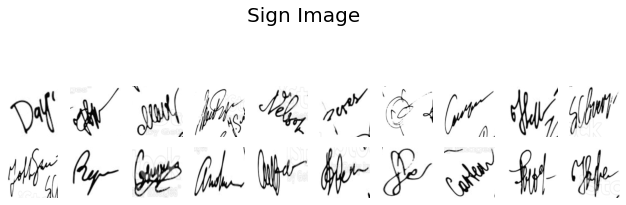

In [ ]:
# 알파벳 이미지 시각화
 
plt.figure(figsize=(11,11))
    
i = 1
for image in train_images:
    plt.subplot(10, 10, i)
    image = image.reshape(width, height)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    i+=1
    if i > 20: break

plt.suptitle("Sign Image", fontsize = 20)
plt.show()

In [ ]:
# 학습 데이터 batch 준비 (batch size: 256)
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print(train_dataset)

<BatchDataset shapes: (None, 200, 200, 1), types: tf.float32>


In [ ]:
# generator 모델 생성 함수
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50*50*256, use_bias=False, input_shape=(200,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((50, 50, 256)))
    assert model.output_shape == (None, 50, 50, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 50, 50, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 100, 100, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 200, 200, 1)

    return model

In [ ]:
# discriminator 모델 생성 함수
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[200, 200, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
# Generator와 Discriminator 초기 생성
generator = make_generator_model()
discriminator = make_discriminator_model()

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# Discriminator 손실 함수 
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
# Generator 손실 함수 
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# Adam으로 모델의 파라미터 갱신 -> optimization
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# 체크포인트 저장
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# 16개의 노이즈 생성 -> generator로 16개 이미지 생성할 것
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
import torch
import torchvision
from torchvision import transforms

# trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
# trainset = torchvision.datasets.ImageFolder(root = './name/', transform = trans)
# trainset.__getitem__(1)

# 1. 새로운 이미지를 원래 noise 크기로 만들어서 이름 사진을 가운데에 넣고 그 이미지로 시도
# 2. 이미지 크기를 계산해서 layer 크기 조정
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)
  image = tf.image.resize(image, [200,200]).numpy()
  image = np.squeeze(image)
  input_image = tf.cast(image, tf.float32)
  return input_image

# input 변수에 이미지에서 변환된 tensor를 저장
input = load('./handwriting_name.jpg')
print(input.shape)
print(type(input))

@tf.function
def train_step(images):

    # noise = tf.random.normal([BATCH_SIZE, noise_dim])
    # print(type(noise))
    # print(noise.shape)

    # image = Image.open('./name/handwriting_name.jpg')
    # trans = transforms.ToTensor()
    # image_t = trans(image)
    # print(image_t.shape)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(input, training=True)-
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

(200, 200)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
noise = tf.random.normal([BATCH_SIZE, noise_dim])
print(type(noise))
print(noise.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(256, 100)


In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # 학습 과정을 보여주는 gif를 위한 이미지 생성
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # 15 에폭이 지날 때마다 체크포인트 저장
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  # generator가 생성한 16개의 이미지 출력 및 저장
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
%%time
train(train_dataset, EPOCHS)

ValueError: ignored

In [ ]:
# 마지막 체크포인트 저장
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# 학습 과정 보여주는 gif 생성
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 학습된 Generator 모델 저장
!mkdir -p saved_model
generator.save('/content/gdrive/My Drive/GAN-model/z-generator')